In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

In [2]:
file_path = "data.csv"

In [3]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
data = data_backup[["spx_ret", "spx"]]

In [5]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

In [6]:
ses_model = SimpleExpSmoothing(train_df["spx_ret"][1:])
ses_model_results = ses_model.fit()

In [7]:
ses_predictions = ses_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

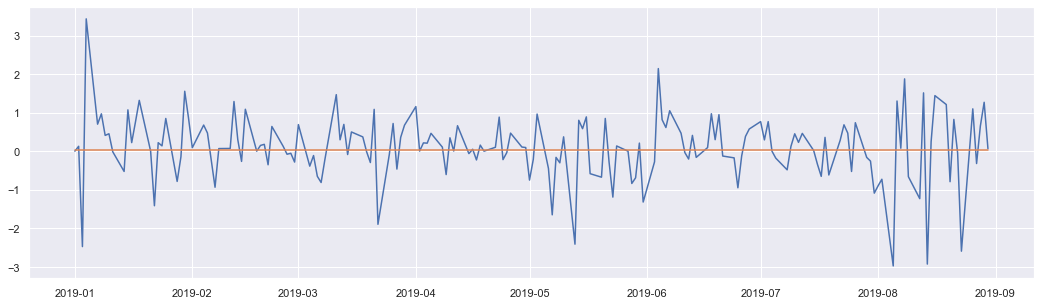

In [8]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(ses_predictions)

plt.show()

## Double Exponential Smoothing (Trend)

In [9]:
des_model = Holt(train_df["spx_ret"][1:], exponential = False, damped_trend = True)
des_model_results = des_model.fit()

In [10]:
des_predictions = des_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

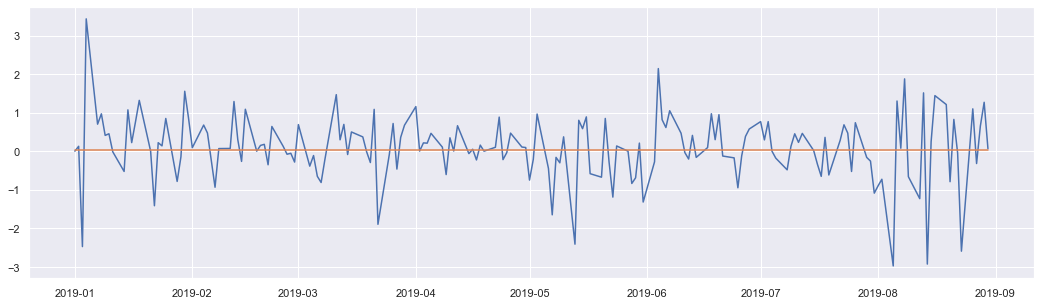

In [11]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(des_predictions)

plt.show()

## Triple Exponential Smoothing (Trend + Seasonality)

In [12]:
tes_model = ExponentialSmoothing(train_df["spx_ret"][1:], 
                                 trend = "add", damped_trend = True,
                                 seasonal = "add", seasonal_periods = 5)
tes_model_results = tes_model.fit()

In [13]:
tes_predictions = tes_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

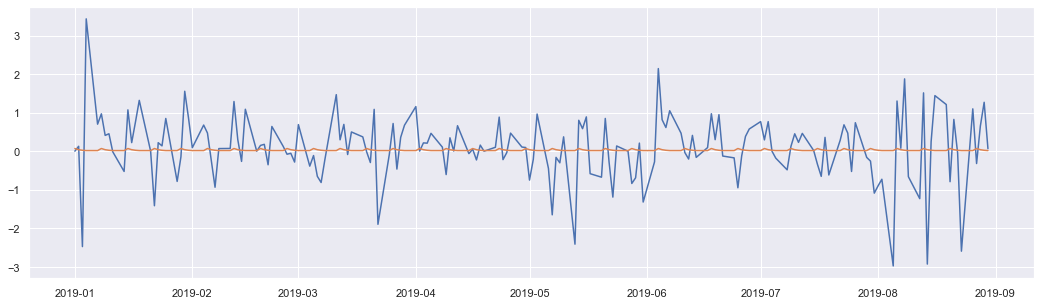

In [14]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(tes_predictions)

plt.show()

## Accuracy Comparision

In [15]:
mean_squared_error(test_df["spx_ret"].values, ses_predictions)

0.7330381374388841

In [16]:
mean_squared_error(test_df["spx_ret"].values, des_predictions)

0.7330779787904137

In [17]:
mean_squared_error(test_df["spx_ret"].values, tes_predictions)

0.7318052186371219

# Parameter Tuning

In [18]:
def fit_exp_smo_model(train_data, params):
    (t, d, s, sp, u) = params
    model = ExponentialSmoothing(train_data, trend = t, damped = d, seasonal = s, seasonal_periods = sp)
    model_fit = model.fit(optimized = True, use_boxcox = u)
    return model_fit

In [19]:
trend = ["add", "mul", None]
damped = [True, False]
seasonal = ["add", "mul", None]
seasonal_periods = [5]
use_boxcox = [True, False, "log", float]


best_mse = float('inf')

count = 0

for t in trend:
    for d in damped:
        for s in seasonal:
            for sp in seasonal_periods:
                for u in use_boxcox:
                    try:
                        count = count + 1
                        params = (t, d, s, sp, u)
                        model = fit_exp_smo_model(train_df["spx_ret"][1:], params)

                        model_predictions = model.predict(start = test_df.index[0], end = test_df.index[-1])
                        model_mse = mean_squared_error(test_df["spx_ret"].values, model_predictions)

                        if model_mse < best_mse:
                            best_mse = model_mse
                            best_params = params
                    except:
                        continue

- **Number of Models Compared**

In [20]:
count

72

In [21]:
(t, d, s, sp, u) = best_params
print(f"trend - {t}")
print(f"damped - {d}")
print(f"seasonal - {s}")
print(f"seasonal_periods - {sp}")
print(f"use_boxcox - {u}")

trend - add
damped - True
seasonal - add
seasonal_periods - 5
use_boxcox - False


In [22]:
best_mse

0.7318052186371219

# Final Model: Triple Smoothening

In [23]:
final_model = ExponentialSmoothing(train_df["spx_ret"][1:], 
                                 trend = "add", damped_trend = True,
                                 seasonal = "add", seasonal_periods = 5)
final_model_results = final_model.fit()

In [24]:
final_predictions = final_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

In [29]:
final_rmse = np.sqrt(mean_squared_error(test_df["spx_ret"].values, final_predictions))

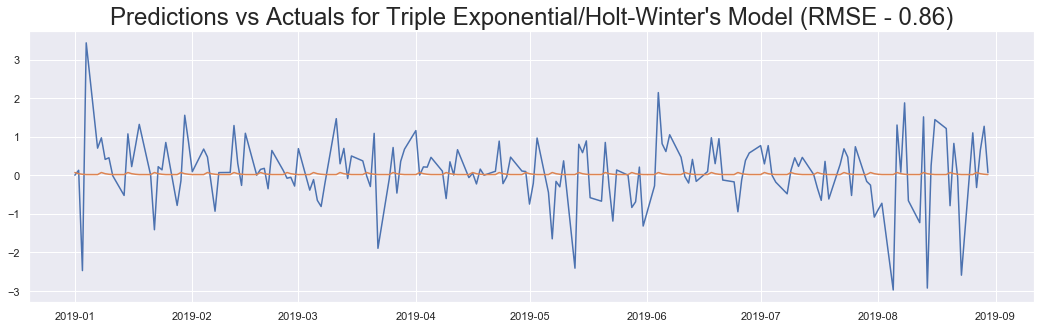

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"])
plt.plot(final_predictions)

plt.title(f"Predictions vs Actuals for Triple Exponential/Holt-Winter's Model (RMSE - {round(final_rmse, 2)})", size = 24)

plt.show()